In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import h5py
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from glob import glob

# Root directory of the project
ROOT_DIR = os.path.abspath('/home/jordanlab/Mask_RCNN')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Following is needed for cudnn when continuing with different resolution
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
classes = {1: 'fish,multifasciatus,brevis'}

class Config(Config):
    NAME = 'brevis_multis'

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(classes) + 1  # background + 1 class

    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 400

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 100
    
config = Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [4]:
from multiprocessing import Lock, Value, Pool, cpu_count
import tqdm

def load_images(i, images, annotation_file, temp):
    path = os.path.join(images[i], 'image')
    img_path = os.path.join(temp, os.path.split(path)[0].replace('/', '-').replace(':', '') + '.png')
    if os.path.exists(img_path):
        height, width = cv2.imread(img_path).shape[:2]
    else:
        with h5py.File(annotation_file, 'r') as h5_file:
            height, width = h5_file[path][:].shape[:2]
            image = h5_file[path][:]
            cv2.imwrite(img_path, image[:, :, ::-1])        
    lock.acquire()
    count.value += 1
    print('Reading images: {:.2f} %'.format(100 * count.value / len(images)),
          sep=' ', end='\r' if count.value < len(images) else '\n', flush=True)
    lock.release()
    return (i, path, width, height)

def init_pool(l, c):
    global lock, count
    lock = l
    count = c

class Dataset(utils.Dataset):

    def load_images(self, annotation_file, classes, source, mode='full'):
        self.classes = classes
        self.annotation_file = annotation_file
        self.temp = os.path.join(os.path.join(os.path.dirname(annotation_file), os.path.split(annotation_file)[-1] + 'temp'))
        if not os.path.exists(self.temp):
            os.mkdir(self.temp)
        with h5py.File(self.annotation_file, 'r') as h5_file:
            for c in self.classes:
                self.add_class(source, c, self.classes[c])
            self.images = h5_file['annotations'][:].astype(np.str)
        np.random.seed(0)
        image_idx = np.arange(self.images.size)
        val_idx = np.random.choice(image_idx, image_idx.size // 6)
        if mode == 'train':
            self.images = self.images[np.invert(np.isin(image_idx, val_idx))]
        elif mode == 'val':
            self.images = self.images[np.isin(image_idx, val_idx)]
        else:
            print('Warning: set mode to "train" or "val", otherwise using full dataset')
        
        l = Lock()
        c = Value('d', 0)
        with Pool(processes=cpu_count(), initializer=init_pool, initargs=(l, c)) as pool:
            to_add = pool.starmap(load_images, list(zip(np.arange(len(self.images)),
                                                        [self.images] * len(self.images),
                                                        [self.annotation_file] * len(self.images),
                                                        [self.temp] * len(self.images))))
        for (i, path, width, height) in to_add:
            self.add_image(source, image_id=i, path=path, width=width, height=height)

    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        img_path = os.path.join(self.temp, os.path.split(path)[0].replace('/', '-').replace(':', '') + '.png')
        image = cv2.imread(img_path)[:, :, ::-1]
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        img_path = info['path']
        path = os.path.split(img_path)[0]
        with h5py.File(self.annotation_file, 'r') as h5_file:
            mask = h5_file[os.path.join(path, 'mask')][:]
            classes = h5_file[os.path.join(path, 'class_names')][:].astype(np.str)
        class_ids = np.array([c for name in classes for c in self.classes if name in self.classes[c]], dtype=np.int32)
        non_empty = mask.sum(axis=(0, 1)) > 10
        return mask[:, :, non_empty], class_ids[non_empty]
    
    def prepare(self):
        super().prepare()
        print('{} images, classes: '.format(len(self.image_ids)), *['[{}: {}]'.format(idx, self.classes[idx]) for idx in self.classes])

In [5]:
augmentation = iaa.Sequential([   
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=iap.Choice([0,90,180,270]))
    ], random_order=True)

In [6]:
# Training dataset
dataset_train = Dataset()
dataset_train.load_images(annotation_file='/home/jordanlab/Documents/multi_brevis_full.h5',
                          classes=classes,
                          source='brevis_multis',
                          mode = 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = Dataset()
dataset_val.load_images(annotation_file='/home/jordanlab/Documents/multi_brevis_full.h5',
                        classes=classes,
                        source='brevis_multis',
                        mode = 'val') 
dataset_val.prepare()

Reading images: 100.00 %
1776 images, classes:  [1: fish,multifasciatus,brevis]
Reading images: 100.00 %
321 images, classes:  [1: fish,multifasciatus,brevis]


In [ ]:
image_ids = np.random.choice(dataset_val.image_ids , 3)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names, limit=1)

In [7]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

# Which weights to start with?
init_with = 'last'  # coco, or last

if init_with == 'coco':
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 
                                'mrcnn_bbox', 'mrcnn_mask']) # 'conv1'
elif init_with == 'last':
    model.load_weights(model.find_last(), by_name=True)

W0801 11:04:55.908044 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 11:04:55.921629 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 11:04:55.955564 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 11:04:55.974841 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_n

Re-starting from epoch 100


In [8]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=110, 
            layers='heads',
            augmentation=augmentation)

W0801 11:05:07.624094 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.




Starting at epoch 100. LR=0.001

Checkpoint Path: /home/jordanlab/Mask_RCNN/logs/brevis_multis20190731T1604/mask_rcnn_brevis_multis_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/engine/trai

Epoch 101/110
400/400 [==============================] - 121s 302ms/step - loss: 0.5048 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1625 - val_loss: 0.9315 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.4616 - val_mrcnn_class_loss: 0.0354 - val_mrcnn_bbox_loss: 0.1769 - val_mrcnn_mask_loss: 0.2557
Epoch 102/110
400/400 [==============================] - 100s 251ms/step - loss: 0.4651 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1642 - val_loss: 0.9267 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.4766 - val_mrcnn_class_loss: 0.0461 - val_mrcnn_bbox_loss: 0.1798 - val_mrcnn_mask_loss: 0.2170
Epoch 103/110
400/400 [==============================] - 99s 247ms/step - loss: 0.5023 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1656 - val_loss: 1.1809 

In [9]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=130,
            layers='all',
            augmentation=augmentation)


Starting at epoch 110. LR=0.0001

Checkpoint Path: /home/jordanlab/Mask_RCNN/logs/brevis_multis20190731T1604/mask_rcnn_brevis_multis_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jordanlab/miniconda3/envs/cuda/lib/python3.7/site-packages/keras/engine/trai

Epoch 111/130
400/400 [==============================] - 214s 534ms/step - loss: 0.5551 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2480 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.1754 - val_loss: 0.9118 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.4787 - val_mrcnn_class_loss: 0.0174 - val_mrcnn_bbox_loss: 0.1757 - val_mrcnn_mask_loss: 0.2379
Epoch 112/130
400/400 [==============================] - 182s 454ms/step - loss: 0.4828 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1633 - val_loss: 0.6986 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.3398 - val_mrcnn_class_loss: 0.0300 - val_mrcnn_bbox_loss: 0.1174 - val_mrcnn_mask_loss: 0.2086
Epoch 113/130
400/400 [==============================] - 183s 457ms/step - loss: 0.4399 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1668 - val_loss: 0.9577

In [11]:
class InferenceConfig(Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
batch_size = inference_config.BATCH_SIZE

In [12]:
classes = {1: 'fish'}

In [13]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model.load_weights(model.find_last(), by_name=True)

W0801 12:56:54.617864 140475309516608 deprecation_wrapper.py:119] From /home/jordanlab/Mask_RCNN/mrcnn/model.py:721: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0801 12:56:54.686498 140475309516608 deprecation.py:323] From /home/jordanlab/Mask_RCNN/mrcnn/model.py:773: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 130


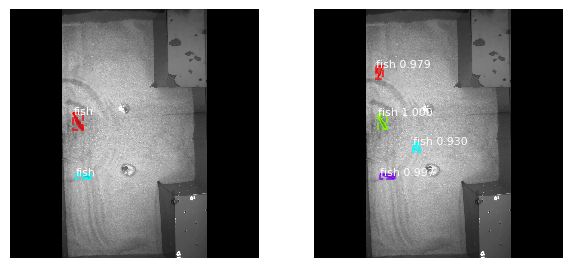

In [17]:
threshold = 0.0


image_id = random.choice(dataset_val.image_ids)
# for image_id in dataset_val.image_ids:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8), ax=ax[0])

results = model.detect([original_image], verbose=0)

r = results[0]
visualize.display_instances(original_image, r['rois'][r['scores'] > threshold], r['masks'][:, :, r['scores'] > threshold], r['class_ids'][r['scores'] > threshold], 
                            dataset_val.class_names, r['scores'][r['scores'] > threshold], ax=ax[1])

plt.show()

In [ ]:
import skvideo.io

threshold = 0.0

video_path = '/home/jordanlab/Videos/shorter - crop video'
output_path = '/home/jordanlab/Videos/shorter - crop video'

if not os.path.exists(output_path):
    os.makedirs(output_path)

video_files = sorted(glob(os.path.join(video_path, 'brevis*.mp4')))

for video_file in video_files:
    
    queue = []
    images = []
    results = []
    frame_idx = 0

    video_name = os.path.splitext(os.path.basename(video_file))[0]
    with h5py.File(os.path.join(output_path, 'predictions_' + video_name + '.h5'), 'w') as h5_file:

        predictions = h5_file.create_dataset('predictions', shape=(0, ), maxshape=(None, ), dtype='|S200')

        cap = skvideo.io.vreader(video_file)
        
        if not os.path.exists(os.path.join(output_path, 'predictions_' + video_name)):
            os.makedirs(os.path.join(output_path, 'predictions_' + video_name))

        for idx, frame in enumerate(cap):
            
            images.append(frame)
            tiles = [frame]
#             tiles = generate_tiles(frame, size=1024, as_list=True)
            queue.extend(tiles)
            
            while len(queue) >= batch_size:
                results.extend(model.detect(queue[:batch_size]))
                queue = queue[batch_size:]

            while len(results) >= len(tiles):
                    
                r = results[0]
#                 r = stitch_predictions(results[:len(tiles)], images[0].shape, size=1024)
                
                masked_img = draw_instances(images[0], r['rois'][r['scores'] > threshold], r['masks'][:, :, r['scores'] > threshold], r['class_ids'][r['scores'] > threshold], 
                            dataset_val.class_names, r['scores'][r['scores'] > threshold])
                cv2.imwrite(os.path.join(output_path, 'predictions_' + video_name, 'pred_{:>05}.jpg').format(frame_idx), cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))
                
                group = h5_file.create_group(str(frame_idx))
                group.create_dataset('masks', data=r['masks'], compression="gzip", compression_opts=9)
                group.create_dataset('scores', data=r['scores'])
                group.create_dataset('classes', data=np.array([classes[c] for c in r['class_ids']], dtype=np.bytes_))
                
                predictions.resize((predictions.shape[0] + 1, ))
                predictions[-1] = np.bytes_(str(frame_idx))
                
                frame_idx += 1
                images = images[1:]
                results = results[len(tiles):]
                
                print('{}'.format(frame_idx), sep=' ', end='\r', flush=True)


In [19]:
def generate_tiles(img, size=512, overlap=100, shifts=1, as_list=False):
    height, width = img.shape[:2]
    origins = np.mgrid[0:height:(size // shifts - overlap),0:width:(size // shifts - overlap)].T.reshape(-1,2)
    imgs = []
    for tl in origins:
        tile = img[tl[0]:(tl[0] + size), tl[1]:(tl[1] + size)]
        if tile.shape[0] < size and tile.shape[1] == size:
            tile = img[(height - size):height, tl[1]:(tl[1] + size)]
        elif tile.shape[0] == size and tile.shape[1] < size:
            tile = img[tl[0]:(tl[0] + size), (width - size):width]
        elif tile.shape[0] < size and tile.shape[1] < size:
            tile = img[(height - size):height, (width - size):width]
        imgs.append(tile)
    if as_list:
        return imgs
    return np.stack(imgs, axis=2)

def stitch_tiles(tiles, target_shape, size=512, overlap=100, shifts=1, flatten=False):
    height, width = target_shape[:2]
    origins = np.mgrid[0:height:(size // shifts - overlap),0:width:(size // shifts - overlap)].T.reshape(-1,2)
    img = np.zeros((height, width, np.sum([tile.shape[2] for tile in tiles])), dtype=np.uint8)
    idx = 0
    for tile, tl in zip(tiles, origins):
        if tl[0] + size > height:
            tl[0] = height - size
        if tl[1] + size > width:
            tl[1] = width - size
        img[tl[0]:(tl[0] + size), tl[1]:(tl[1] + size), idx:(idx + tile.shape[2])] = tile
        idx += tile.shape[2]
    if flatten:
        img = img.sum(axis=(2)) > 0
    return img

def stitch_rois(rois, target_shape, size=512, overlap=100, shifts=1):
    height, width = target_shape[:2]
    origins = np.mgrid[0:height:(size // shifts - overlap),0:width:(size // shifts - overlap)].T.reshape(-1,2)
    for idx, (roi, tl) in enumerate(zip(rois, origins)):
        if tl[0] + size > height:
            tl[0] = height - size
        if tl[1] + size > width:
            tl[1] = width - size
        rois[idx][:, ::2] += tl[0]
        rois[idx][:, 1::2] += tl[1]
    rois = np.concatenate(rois)
    return rois

def stitch_predictions(results, target_shape, size=512, overlap=100, shifts=1):
    stitched_result = {}
    stitched_result['masks'] = stitch_tiles([result['masks'] for result in results], target_shape, size, overlap, shifts)
    stitched_result['rois'] = stitch_rois([result['rois'] for result in results], target_shape, size, overlap, shifts)
    stitched_result['scores'] = np.concatenate([result['scores'] for result in results])
    stitched_result['class_ids'] = np.concatenate([result['class_ids'] for result in results])
    return stitched_result

import colorsys
from glob import glob
import h5py
import skvideo.io

def split_image(image, overlap=1/6):
    shape = image.shape[:2]
    overlap = round(min(shape) * overlap / 2)
    ul = np.concatenate([np.array([0, 0]), np.array(shape) / 2 + overlap]).astype(np.int)
    ur = np.array([0, shape[1] / 2 - overlap, shape[0] / 2 + overlap, shape[1]]).astype(np.int)
    bl = np.array([shape[0] / 2 - overlap, 0, shape[0], shape[1] / 2 + overlap]).astype(np.int)
    br = np.concatenate([np.array(shape) / 2 - overlap, shape]).astype(np.int)
    ul = image[ul[0]:ul[2], ul[1]:ul[3]]
    ur = image[ur[0]:ur[2], ur[1]:ur[3]]
    bl = image[bl[0]:bl[2], bl[1]:bl[3]]
    br = image[br[0]:br[2], br[1]:br[3]]
    return [ul, ur, bl, br]

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.2):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
        image = image.astype(np.uint8)
    return image


def draw_instances(image, boxes, masks, class_ids, class_names, scores=None):
    if len(image.shape) > 2 and image.shape[2] == 1:
        image = np.stack([image.reshape(*image.shape[:2])] * 3, axis=2)
    N = boxes.shape[0]
    if not N:
        return image
    else:
        colors = random_colors(N)
        height, width = image.shape[:2]
        masked_image = image.astype(np.uint32).copy()
        for i in range(N):
            color = colors[i]
            if not np.any(boxes[i]):
                continue
            y1, x1, y2, x2 = boxes[i]
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            color = [int(c) * 255 for c in color]
            cv2.rectangle(masked_image, (x1, y1), (x2, y2), color, 1, cv2.LINE_AA)
            cv2.putText(masked_image, caption, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return masked_image